# ディープラーニングを適用した画像検索システム (demo)

学習済ニューラルネットワークVGG16を用いて，画像の特徴ベクトルを生成します．
生成した画像の特徴ベクトルを用いて画像検索を行います．

# 1. 画像の読み込み
C
altech 256の画像データセットから、約30,000枚の画像を読み込みます。

In [7]:
import os
 
path = 'D:\\dataset\\demo\\256_ObjectCategories'
 
filelist = []
    
for d in os.listdir(path):
    if os.path.isdir(os.path.join(path, d)):
        subpath = os.path.join(path, d)
        for imgf in os.listdir(subpath):
            if os.path.isfile(os.path.join(subpath, imgf)):
                filelist.append(imgf)
 


In [ ]:
print(filelist)

# 2. 学習済の画像認識ニューラルネットワークの準備

学習済の画像認識ニューラルネットワークとしてVGG16を準備します。

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np

# model = VGG16(weights='imagenet', include_top=True)
base_model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)


Using TensorFlow backend.


In [3]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
#img_path = 'elephant.jpg'
img_path = 'D:\\dataset\\demo\\256_ObjectCategories\\003.backpack\\003_0001.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

In [4]:
print(features)
print(features.shape)

[[4.8124847 7.780907  0.        ... 0.        0.        0.       ]]
(1, 4096)


In [5]:
model2 = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

img_path = 'D:\\dataset\\demo\\256_ObjectCategories\\003.backpack\\003_0001.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features2 = model2.predict(x)

print(features2)
print(features2.shape)

[[0.         0.         2.1568074  ... 0.08898768 0.32180887 0.35184997]]
(1, 4096)


# 3. 画像特徴ベクトルの生成

Caltech 256の30,000枚の画像データを､VGG16を用いてベクトル化します。

In [6]:
import os
 
path = 'D:\\dataset\\demo\\256_ObjectCategories'
count = 0

feature_list = []
image_list = []
for d in os.listdir(path):
    if count > 10:
        break
        
    if os.path.isdir(os.path.join(path, d)):
        subpath = os.path.join(path, d)
        for imgf in os.listdir(subpath):
            if os.path.isfile(os.path.join(subpath, imgf)):
                img_path = os.path.join(subpath, imgf)
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                features = model2.predict(x)
                # print(imgf, features)
                image_list.append(img)
                feature_list.append(features[0])
                
    count = count + 1
    

feature_list = np.array(feature_list)    
#print(feature_list)
print (count)

11


# 4. 画像検索処理をするクラスの定義

上位n件を検索するクラスを定義します。
距離計算には、マンハッタン距離を用います。

In [8]:
class CBIR(object):
    def __init__(self):
        pass

    def train(self, X):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.X = X
    
    def search(self, q, k):
        distances = np.sum(np.abs(self.X - q), axis = 1)
        
        sorted_indexes = np.argsort(distances)
        #max_k = sorted_indexes[-(k+1):-1]
        min_k = sorted_indexes[:k+1]
        
        #return max_k
        return min_k

# 5. Deep Learningよる画像検索

画像検索結果の例を示します。

1. 問い合わせを q_idx で指定します。
2. 上位6件の結果を表示します。左から順に関連のある画像が表示されます。
（一番左は自分自身の画像になっています。）

In [12]:
q_idx = 350
q = feature_list[q_idx,:]

In [13]:
cbir = CBIR() # create a Nearest Neighbor classifier class
cbir.train(feature_list) # train the classifier on the training images and labels
result = cbir.search(q, 6) # predict labels on the test images

[350 455 428 463 430 445 431]


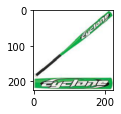

In [15]:
import matplotlib.pyplot as plt

print(result)

plt.figure(figsize=(10,10))
cifar_img=plt.subplot(1,6,1)
plt.imshow(image_list[q_idx])

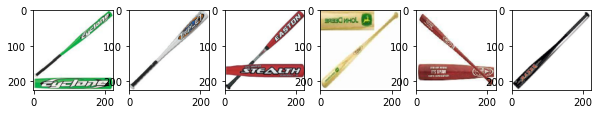

In [16]:
plt.figure(figsize=(10,10))

cifar_img=plt.subplot(5,6,1)
plt.imshow(image_list[result[0]])

cifar_img=plt.subplot(5,6,2)
plt.imshow(image_list[result[1]])

cifar_img=plt.subplot(5,6,3)
plt.imshow(image_list[result[2]])

cifar_img=plt.subplot(5,6,4)
plt.imshow(image_list[result[3]])

cifar_img=plt.subplot(5,6,5)
plt.imshow(image_list[result[4]])

cifar_img=plt.subplot(5,6,6)
plt.imshow(image_list[result[5]])